# Ranked batch-mode sampling

## Overview

In this example, we apply an `ActiveLearner` onto the iris dataset using **ranked batch-mode active learning**. Much like pool-based sampling, in this setting we assume a small (potentially empty) set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$.

One of the drawbacks of standard pool-based sampling (indeed, most sampling techniques) is their interactive nature: these sampling methods are best fit for cases where we have an attentive human-in-the-loop for maximizing the model's performance. Although these sampling methods (ours included!) _do_ support returning multiple samples per query, they tend to return redundant/sub-optimal queries if we return more than one instance from the unlabeled set. This is a bit prohibitive in settings where we'd like to ask an active learner to return multiple (if not all) examples from the unlabeled set/pool.

This implementation (see the original issue [here](https://github.com/cosmic-cortex/modAL/issues/11)) implements Cardoso et al.'s **ranked batch-mode** sampling, which not only supports batch-mode sampling (sampling methods that are built with querying multiple labels from the unlabeled set) but also establishes a _ranking_ among the batch in order for end-users to prioritize which records to label from the unlabeled set. In their own words:

> Our new approach allows the algorithm to generate an arbitrarily long query, thus making its execution less frequent. For example, a ranked query containing every available instance could be generated outside working hours. This would allow hired analysts to label instances for a full day, in parallel, if desired, without waiting for the learner update and query reconstruction.

For further reading on ranked batch-mode active learning, we highly recommend the following resources:

- Thiago N.C. Cardoso, Rodrigo M. Silva, Sérgio Canuto, Mirella M. Moro, Marcos A. Gonçalves. [Ranked batch-mode active learning](http://www.sciencedirect.com/science/article/pii/S0020025516313949). Information Sciences, Volume 379, 2017, Pages 313-337.

## Note

Although this notebook only highlights the benefits of batch sampling (as opposed to interactive sampling), the same ideas hold for ranked batch-mode sampling. One day we'll get around to producing examples where ranked batch-mode sampling is the core idea being evaluated :)

To enforce a reproducible result across runs, we set a random seed.

In [1]:
import numpy as np

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

## The dataset

Now we load the dataset. In this example, we are going to use the famous Iris dataset. For more information on the iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data'] 
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks like.

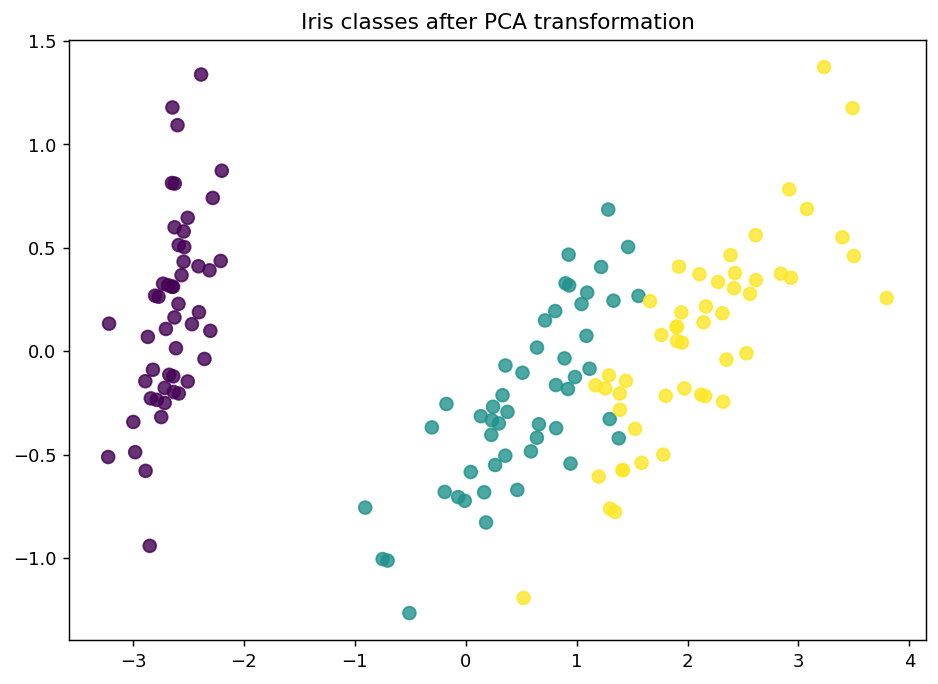

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [5]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

## Active learning with ranked batch mode sampling

For the classification, we are going to use a simple k-nearest neighbors classifier.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)

Now we initialize the ```ActiveLearner```.

In [16]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=knn, 
  
  X_training=X_train,
  y_training=y_train, 
  
  query_strategy=preset_batch
)

Let's see how our classifier performs on the initial training set!

In [17]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

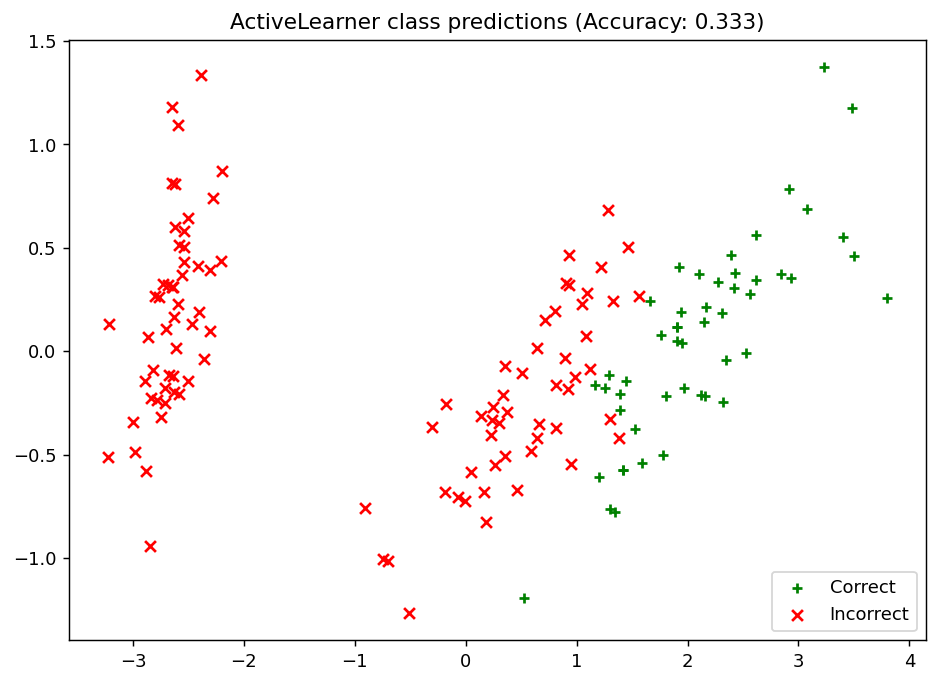

In [18]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

Now we Update our model by batch-mode sampling our "unlabeled" dataset $\mathcal{U}$. We tune our classifier by allowing it to query at most 20 instances it hasn't seen before. To properly utilize batch-mode sampling, we allow our model to request three records per query (instead of 1) but subsequently only allow our model to make 6 queries. Under the hood, our classifier aims to balance the ideas behind uncertainty and dissimilarity in its choices.

With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [19]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)
    
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)
    
    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)
    
    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.8933
Accuracy after query 2: 0.8400
Accuracy after query 3: 0.9267
Accuracy after query 4: 0.9333
Accuracy after query 5: 0.9467
Accuracy after query 6: 0.9533


## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. As you can see, our model is able to obtain an accuracy of ~0.90 within its first query, and isn't as susceptible to getting "stuck" with querying uninformative records from our unlabeled set.
To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

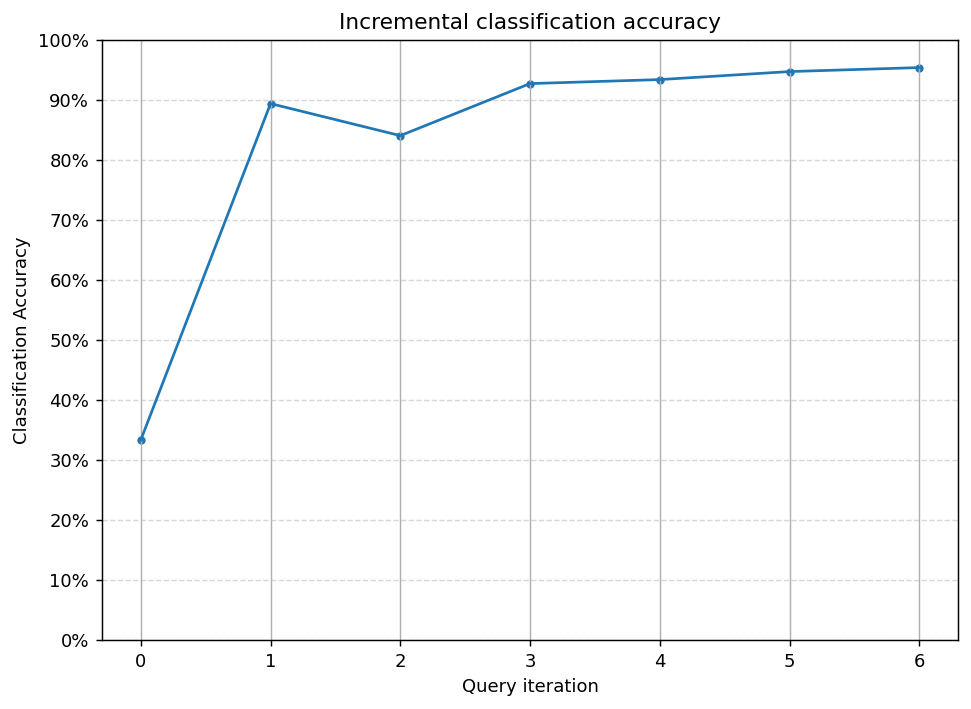

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

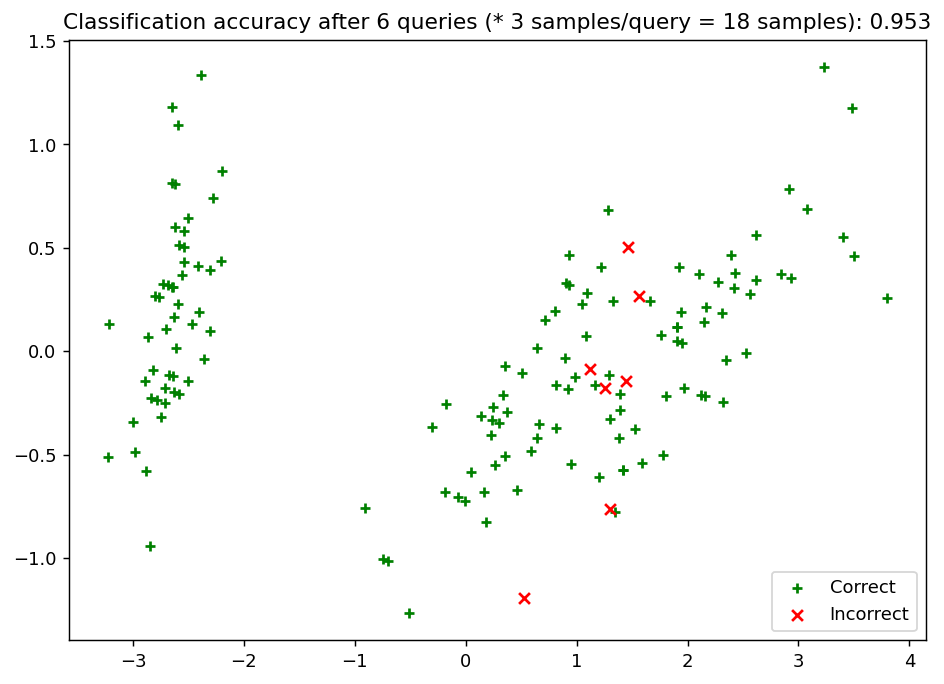

In [21]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
    n=N_QUERIES, 
    batch_size=BATCH_SIZE,
    total=N_QUERIES * BATCH_SIZE,
    final_acc=performance_history[-1]
))
ax.legend(loc='lower right')

plt.show()